# 📊 Análisis de Abandono de Clientes en un Banco Comercial.
---

## 🎯 1. Objetivo del análisis y preguntas claves

El objetivo principal de este análisis es **comprender los factores que inciden en la pérdida de clientes**, y construir un modelo predictivo que permita **anticipar qué clientes tienen mayor probabilidad de abandonar**. Esto permitirá a la empresa diseñar estrategias proactivas de retención.

**Preguntas claves:**

- ¿Qué características distinguen a los clientes que abandonan de los que permanecen?
- ¿Existen patrones comunes en los hábitos de consumo o atributos financieros de los clientes que se van?
- ¿Qué variables son más relevantes para predecir el abandono?
- ¿Es posible construir un modelo fiable que anticipe la probabilidad de abandono?

**Hipótesis:**

1) Los clientes que realizan un menor número de transacciones mensuales tienen una mayor probabilidad de abandono.

2) Los clientes con un mayor límite de crédito tienen una mayor probabilidad de quedarse.

3) No hay grandes diferencias en género, nivel educativo o estado civil entre aquellos que fueron clientes del banco y aquellos actuales.



---

## 🏦 2. Contexto comercial

En el sector bancario, **retener clientes es más rentable que adquirir nuevos**. La pérdida de un cliente representa no solo ingresos futuros perdidos, sino también costos indirectos como campañas de marketing, promociones o daño a la imagen de la marca.

Comprender las causas del abandono permite:
- **Reducir pérdidas económicas**
- **Optimizar campañas de fidelización**
- **Tomar decisiones basadas en datos**

---

## ❗ 3. Problema comercial

La empresa enfrenta una **tasa creciente de abandono de clientes** sin comprender del todo sus causas. Esta situación compromete la rentabilidad del negocio, ya que se pierden clientes valiosos y no existe una estrategia efectiva de contención.

El problema se resume en:
- Identificar **tempranamente a los clientes en riesgo de abandonar**
- Implementar **acciones de retención personalizadas y eficientes**

---

## 🧠 4. Contexto analítico

Se dispone de un dataset con información detallada de clientes de un banco comercial, incluyendo:

- **Variables demográficas** (Género, Estado civil, Nivel educativo, etc.)
- **Variables financieras** (Ingresos, Límite de crédito, etc.)
- **Comportamiento transaccional** (Cantidad e importe de transacciones, uso de productos, etc.)
- **Variable objetivo:** `Attrition_Flag`, que indica si el cliente ha abandonado (`Attrited Customer`) o permanece (`Existing Customer`)

A partir de estos datos se realizarán los siguientes pasos:

- Análisis exploratorio de datos (EDA)
- Visualización de diferencias por grupo
- Selección de variables predictoras
- Entrenamiento y evaluación de modelos
- Recomendaciones comerciales basadas en hallazgos

---


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from collections import Counter

## 1️⃣ Análisis exploratorio de datos (EDA)

In [54]:
# Cargo el dataset
df = pd.read_csv('https://raw.githubusercontent.com/CesarFerrer97/Data-Science-01/refs/heads/main/BankChurners.csv')
print(df.shape )
print(df.columns)

(10127, 23)
Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')


In [55]:
# Elimino las dos últimas columnas dado que no aportan información relevante.
df = df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])
print(df.shape )
print(df.dtypes)

(10127, 21)
CLIENTNUM                     int64
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object


# GLOSARIO DEL DATASET:

* **'CLIENTNUM'**:
    * Número de identificación único para cada cliente.

* **'Attrition_Flag'**:
    * Indica si el cliente ha abandonado el banco (es decir, ha dejado de ser cliente). Está compuesto por "Existing Customer" o "Attrited Customer"  .
* **'Customer_Age'**:
    * Edad del cliente en años.
* **'Gender'**:
    * Género del cliente (por ejemplo, "M" para masculino, "F" para femenino).
* **'Dependent_count'**:
    * Número de personas dependientes del cliente (por ejemplo, hijos, cónyuge).
* **'Education_Level'**:
    * Nivel de educación del cliente (por ejemplo, "Graduate", "High School", "Unknown").
* **'Marital_Status'**:
    * Estado civil del cliente (por ejemplo, "Married", "Single", "Divorced", "Unknown").
* **'Income_Category'**:
    * Categoría de ingresos del cliente (por ejemplo, "$40K-$60K", "Less than $40K", "Unknown").
* **'Card_Category'**:
    * Tipo de tarjeta de crédito que posee el cliente (por ejemplo, "Blue", "Silver", "Gold", "Platinum").
* **'Months_on_book'**:
    * Número de meses que el cliente ha estado con el banco.
* **'Total_Relationship_Count'**:
    * Número total de productos de relación que el cliente tiene con el banco.
* **'Months_Inactive_12_mon'**:
    * Número de meses que el cliente ha estado inactivo en los últimos 12 meses.
* **'Contacts_Count_12_mon'**:
    * Número de veces que el cliente contactó al banco en los últimos 12 meses.
* **'Credit_Limit'**:
    * Límite de crédito de la tarjeta del cliente.
* **'Total_Revolving_Bal'**:
    * Saldo total revolvente en la tarjeta de crédito del cliente.
* **'Avg_Open_To_Buy'**:
    * Promedio del crédito disponible para comprar (límite de crédito menos saldo revolvente).
* **'Total_Amt_Chng_Q4_Q1'**:
    * Cambio en el monto total de transacciones entre el cuarto y el primer trimestre.
* **'Total_Trans_Amt'**:
    * Monto total de transacciones del cliente.
* **'Total_Trans_Ct'**:
    * Número total de transacciones del cliente.
* **'Total_Ct_Chng_Q4_Q1'**:
    * Cambio en el número total de transacciones entre el cuarto y el primer trimestre.
* **'Avg_Utilization_Ratio'**:
    * Promedio de la tasa de utilización de la tarjeta de crédito (saldo revolvente dividido por el límite de crédito).


In [56]:
print("Datos Nulos:\n\n",df.isna().sum())

Datos Nulos:

 CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64


In [57]:
print("Datos Duplicados:\n\n", df.duplicated().sum())

Datos Duplicados:

 0


Como se puede apreciar no se encuentran datos ausentes ni duplicados en el dataset. A continuación, prosiguimos con la exploración visual de algunos campos.

### Gráfico 1: distribución entre clientes actuales y ex clientes.


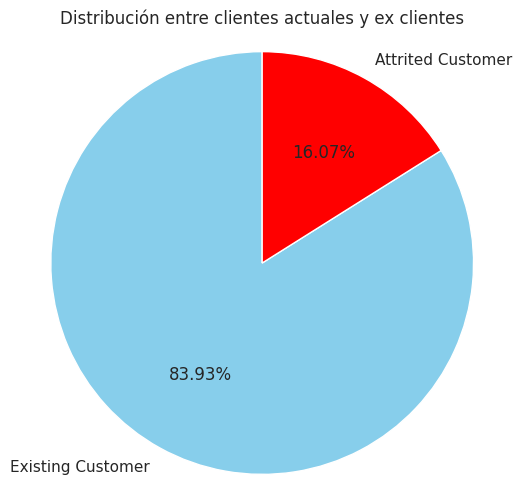

In [58]:
conteos_clientes = df['Attrition_Flag'].value_counts()
colores = ['skyblue', 'red']
plt.figure(figsize=(6, 6))
plt.pie(conteos_clientes, labels= conteos_clientes.index, autopct='%1.2f%%', startangle=90, colors=colores)
plt.title("Distribución entre clientes actuales y ex clientes")
plt.axis('equal')
plt.show()

Como se observa en el Gráfico 1 el  83,93% de los registros en la base de datos corresponden a clientes actuales mientras que 16,07% pertenece a ex clientes.

### Gráfico 2: Composición de Clientes (Actuales y Ex Clientes) por Género.

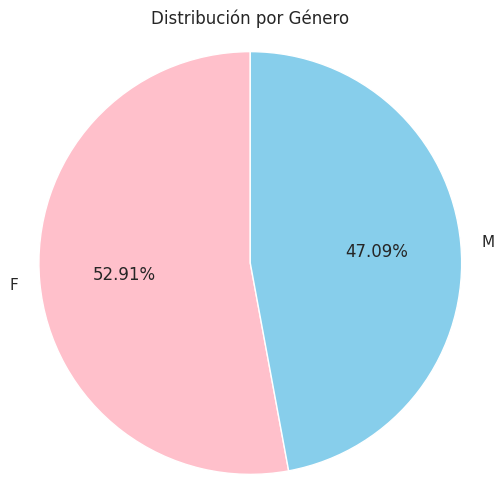

In [59]:
conteos_genero = df['Gender'].value_counts()
colores = ['pink', 'skyblue']
plt.figure(figsize=(6, 6))
plt.pie(conteos_genero, labels=conteos_genero.index, autopct='%1.2f%%', startangle=90, colors=colores)
plt.title('Distribución por Género')
plt.axis('equal')
plt.show()

El Gráfico 2 indica que existe una mayor proporción de mujeres entre los clientes del banco, aunque la diferencia es modesta.

### Gráfico 3: Distribución de clientes (Actuales y Ex Clientes) por rango etario.

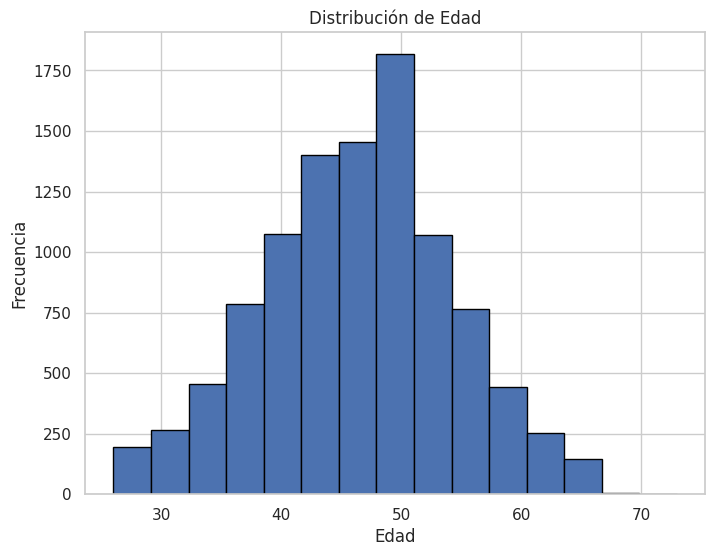

In [60]:
plt.figure(figsize=(8, 6))
plt.hist(df['Customer_Age'], bins=15, edgecolor='black')  # bins define el número de barras
plt.title('Distribución de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

El histograma del Gráfico 3 muestra la distribución de edades en el conjunto de datos, revelando una distribución aproximadamente normal o acampanada, lo que sugiere que la mayoría de las edades se concentran alrededor de la mitad del rango, específicamente entre los 40 y 55 años. Se observa un pico en la frecuencia de individuos alrededor de los 50 años, indicando que este es el grupo de edad más común. La distribución es relativamente simétrica, aunque con una ligera asimetría hacia la derecha, lo que indica que hay un poco más de personas mayores que jóvenes en el conjunto de datos. Como es de esperar las frecuencias disminuyen gradualmente a medida que nos alejamos de la edad central, lo que indica una menor cantidad de individuos en los extremos del rango etario.

### Gráfico 4: Cantidad de clientes (Actuales y Ex Clientes) por nivel educativo.

Text(0, 0.5, 'Nivel educativo')

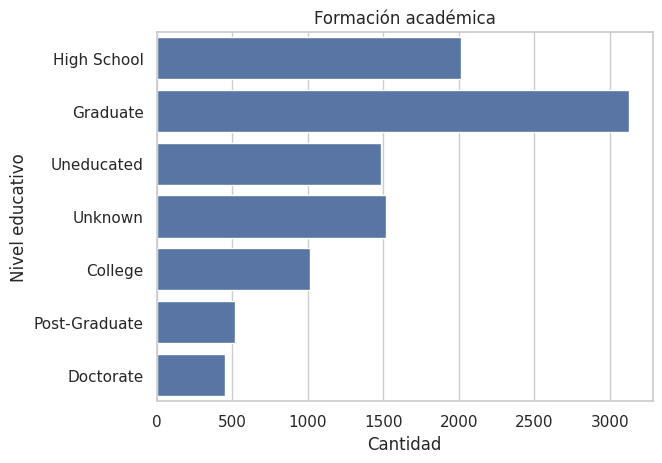

In [61]:
#countplot on 'Education_Level' column
sns.countplot(data=df,y='Education_Level')
plt.title("Formación académica")
plt.xlabel("Cantidad")
plt.ylabel("Nivel educativo")

El Gráfico 4 nos muestra la distribución de la formación académica entre los clientes del banco. Se observa que la mayoría de los clientes tienen un nivel educativo de "Graduate" (graduado), seguido de cerca por aquellos con "High School" (secundaria completa). Es notable la presencia de un número significativo de clientes con educación "Uneducated" (sin educación) y aquellos cuyo nivel educativo es "Unknown" (desconocido). Los niveles educativos más altos, como "Post-Graduate" (posgrado) y "Doctorate" (doctorado), representan una proporción mucho menor de la base de clientes.

Este análisis revela que el banco atiende a una clientela diversa en términos de formación académica, con una fuerte representación de clientes con niveles educativos medios y una presencia considerable de aquellos con niveles educativos más bajos o desconocidos. Esto podría sugerir que el banco ofrece productos y servicios que son accesibles y relevantes para una amplia gama de clientes, independientemente de su nivel educativo.

### Gráfico 5: Cantidad de clientes (Actuales y Ex Clientes) por estado civil.

Text(0, 0.5, 'Cantidad')

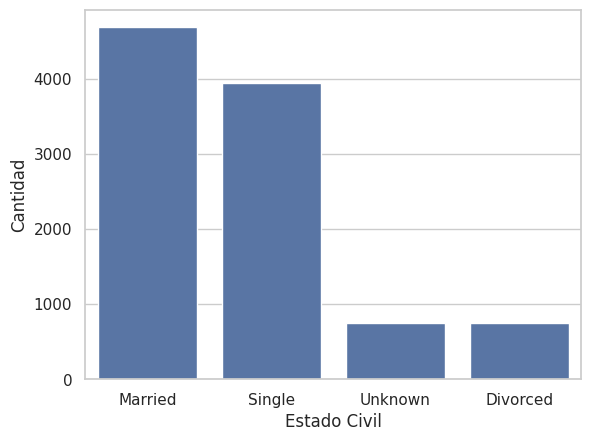

In [62]:
#countplot on 'Marital_Status' column
sns.countplot(data=df,x='Marital_Status')
plt.xlabel("Estado Civil")
plt.ylabel("Cantidad")


Del Gráfico 5 notamos que la mayoría de los clientes están casados (Married), seguidos por un número significativo de clientes solteros (Single). Los clientes divorciados (Divorced) y aquellos con estado civil desconocido (Unknown) representan una proporción mucho menor de la base de clientes.

La alta proporción de clientes casados podría indicar la importancia de ofrecer productos y servicios financieros conjuntos, como cuentas bancarias conjuntas, préstamos hipotecarios o planes de ahorro familiar.

### Gráfico 6: Cantidad de clientes (Actuales y Ex Clientes) por nivel de ingreso.

Text(0, 0.5, 'Cantidad')

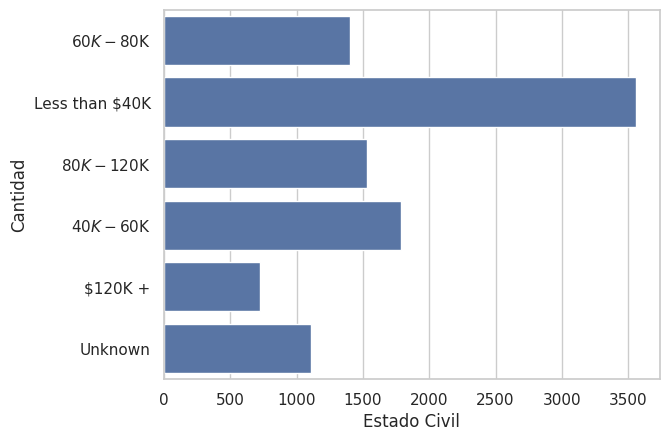

In [63]:
#countplot on 'Income_Category' column
sns.countplot(data=df,y='Income_Category')
plt.xlabel("Estado Civil")
plt.ylabel("Cantidad")


El Gráfico 6 se observa que la mayoría de los clientes tienen ingresos anuales inferiores a 40K seguidos por un número significativo de clientes con ingresos entre 40K y 60K. Los ingresos entre 60K - 80K y 80K - 120K representan una proporción menor de la base de clientes, mientras que los ingresos superiores a los 120K son los menos frecuentes. Además, hay un número considerable de clientes cuyos ingresos son desconocidos.

Este análisis revela que el banco atiende principalmente a clientes con ingresos anuales bajos o medios, lo que podría indicar que sus productos y servicios están diseñados para satisfacer las necesidades financieras de estos grupos demográficos. La baja representación de clientes con ingresos altos podría sugerir la necesidad de estrategias de marketing y productos específicos para este segmento.

Por último, la considerable cantidad de clientes con ingresos desconocidos podría indicar la necesidad de mejorar la recopilación de datos para comprender mejor la situación financiera de los clientes y ofrecer productos y servicios más personalizados.


### Gráfico 7: Cantidad de clientes (Actuales y Ex Clientes) por tipo de tarjeta de crédito.

Text(0, 0.5, 'Cantidad')

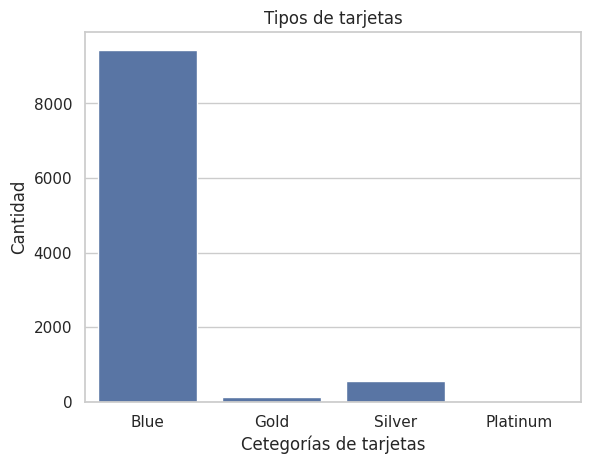

In [64]:
#countplot on 'Card_Category' column
sns.countplot(data=df,x='Card_Category')
plt.title("Tipos de tarjetas")
plt.xlabel("Cetegorías de tarjetas")
plt.ylabel("Cantidad")

El Grafico 7 revela un claro predominio de las tarjetas "Blue" entre los clientes del banco, lo que se alinea con el perfil de ingresos bajos y medios que hemos identificado en el análisis anterior. Esto sugiere que la tarjeta "Blue" es el producto más accesible y popular para la mayoría de la clientela, que tiende a tener ingresos anuales inferiores a $40K.

La baja presencia de tarjetas "Gold", "Silver" y "Platinum" refuerza la idea de que el banco atiende principalmente a clientes con ingresos más modestos. La casi inexistencia de tarjetas "Platinum" en particular, sugiere una limitada penetración en el segmento de clientes de alto poder adquisitivo. Esto podría indicar una necesidad de revisar las estrategias de marketing y los beneficios ofrecidos en las tarjetas premium para hacerlas más atractivas a este segmento. No obstante, también es posible que el banco haya definido que este grupo no forma parte de su mercado objetivo prioritario.

Por último, la  fuerte representación de los clientes en los niveles medios y bajos de educación, podría explicar la alta demanda de tarjetas "Blue", que probablemente tienen requisitos de elegibilidad más flexibles. En conjunto, estos hallazgos nos ofrecen un panorama general del posible público objetivo del banco.

Hecho ya un pantallazo general de los datos. Nos enfocaremos en ver si hay diferencias significativas entre los clientes actuales y los ex clientes. Para ello, comenzaremos analizando las variables categóricas respecto a "Attrition_Flag"

### Gráfico 8: Diferencias entre clientes Actuales y Ex Clientes por tipo de variable categórica.

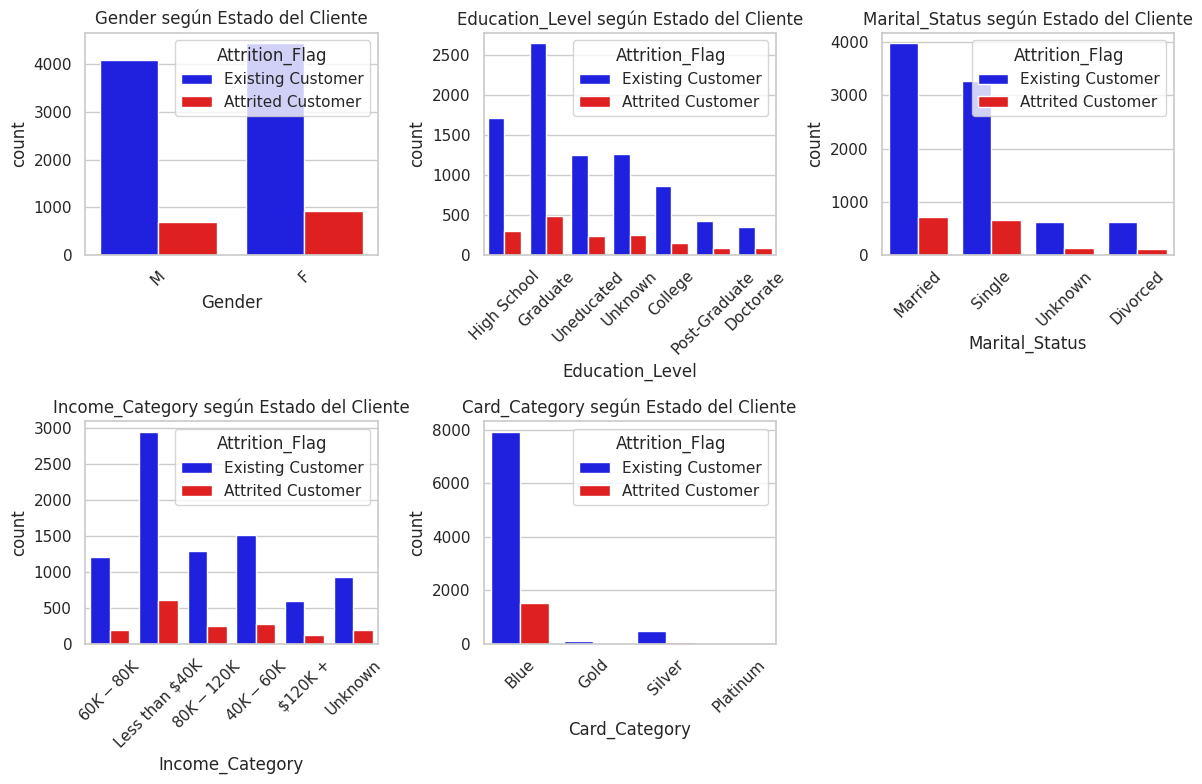

In [65]:
# Variables categóricas a comparar
categorical_vars = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

plt.figure(figsize=(12, 8))
for i, var in enumerate(categorical_vars):
    plt.subplot(2, 3, i + 1)
    sns.countplot(data=df, x=var, hue='Attrition_Flag', palette=['blue', 'red'])
    plt.title(f'{var} según Estado del Cliente')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El análisis de los gráficos que componen el Gráfico 8 revela una aparente ausencia de diferencias significativa entre la pérdida de clientes y las variables categóricas presentes en el conjunto de datos. Este hallazgo sugiere que la exploración de variables numéricas podría ser más fructífera para identificar patrones de abandono. En consecuencia, estos resultados respaldan la hipótesis 3, que postula la inexistencia de diferencias sustanciales entre clientes actuales y ex clientes en relación con estas categorías.

In [66]:
# Transformo la variable objetivo a numérica
df['Attrition_Flag'] = df['Attrition_Flag'].apply(lambda x: 1 if x == "Attrited Customer" else 0)

### Gráfico 9: Tasas de abandono por variable categóricas.

<ipython-input-67-c3770ab9e541>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attrition_rate.index, y=attrition_rate.values, palette="coolwarm")
<ipython-input-67-c3770ab9e541>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attrition_rate.index, y=attrition_rate.values, palette="coolwarm")
<ipython-input-67-c3770ab9e541>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attrition_rate.index, y=attrition_rate.values, palette="coolwarm")
<ipython-input-67-c3770ab9e541>:13: FutureWarning: 

Passing `palette` without assigning `hue`

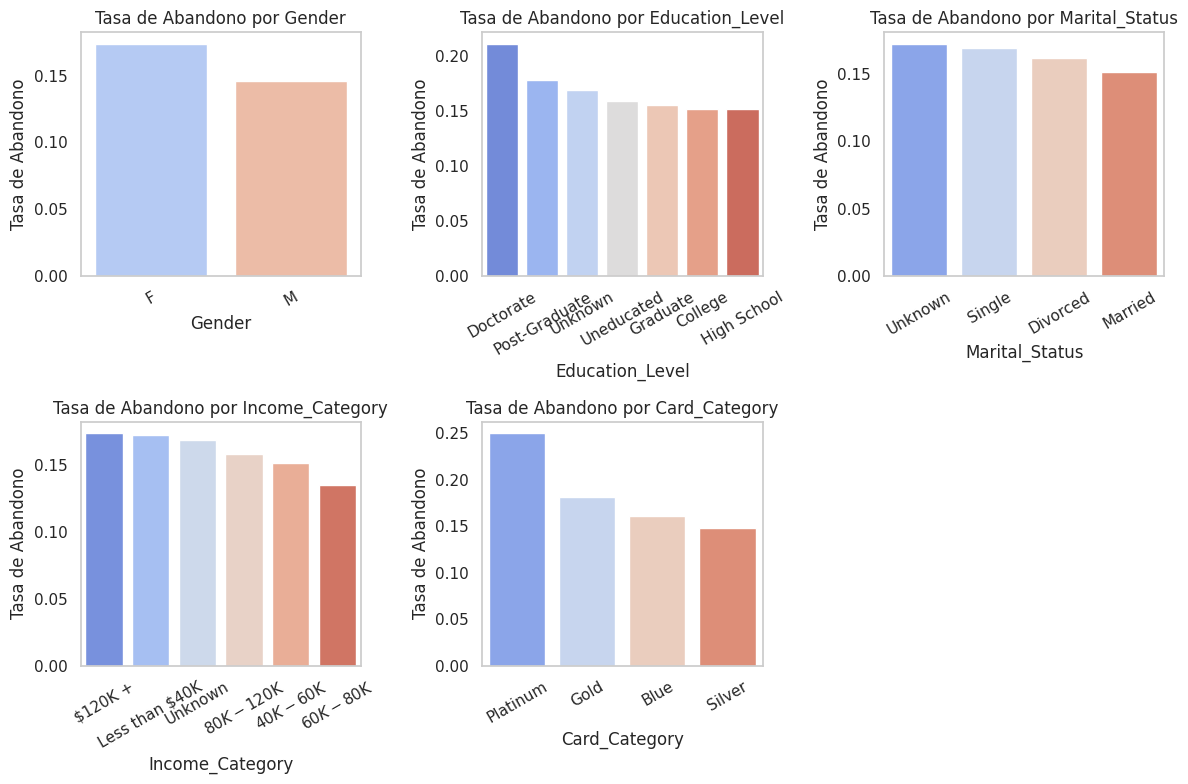

In [67]:
# Establezco estilo
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Graficar cada variable en un subplot
for i, col in enumerate(categorical_vars, 1):
    plt.subplot(2, 3, i)

    # Calcular la tasa de abandono por categoría
    attrition_rate = df.groupby(col)['Attrition_Flag'].mean().sort_values(ascending=False)

    # Crear gráfico
    sns.barplot(x=attrition_rate.index, y=attrition_rate.values, palette="coolwarm")
    plt.title(f'Tasa de Abandono por {col}')
    plt.xlabel(col)
    plt.ylabel('Tasa de Abandono')
    plt.grid(False)
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

Al comparar los gráficos por categoría en valores absolutos con los que muestran tasas de abandono, se revela un panorama mucho más matizado sobre el comportamiento de los distintos grupos. Mientras que los números absolutos destacan a los grupos más numerosos como principales responsables del abandono, las tasas permiten identificar en qué segmentos el abandono es proporcionalmente más alto, es decir, dónde el problema es más agudo en relación con el tamaño del grupo.

Uno de los ejemplos más claros de esta diferencia se observa en la categoría de tarjeta `Card_Category`. En términos absolutos, la mayoría de los abandonos provienen de quienes tienen tarjeta Blue, pero esto se debe simplemente a que es la más común entre los clientes. En cambio, cuando se analiza la tasa de abandono, la tarjeta Platinum muestra el mayor porcentaje, revelando que quienes poseen este tipo de tarjeta tienden a abandonarla con mayor frecuencia relativa. Esto podría indicar un descontento específico en ese segmento, tal vez por no recibir beneficios acordes al nivel de la tarjeta.

Algo similar ocurre con el nivel educativo. Si bien en números absolutos los niveles más frecuentes como "Graduate" o "College" concentran la mayor cantidad de abandonos, al observar las tasas, se destaca que quienes poseen títulos de Doctorado o Posgrado abandonan más proporcionalmente. Esto puede interpretarse como un desajuste entre las expectativas de clientes con mayor formación y los servicios que reciben, lo cual sugiere la necesidad de una estrategia diferenciada para estos perfiles.


La categoría de ingresos `Income_Category` presenta una relación interesante: en números absolutos, los abandonos se concentran en los niveles intermedios, probablemente por ser los más numerosos. Sin embargo, al mirar las tasas, se observa que los extremos—tanto los ingresos más bajos como los más altos—registran tasas de abandono más elevadas. Esto podría deberse, por un lado, a dificultades económicas en los sectores de menores ingresos y, por otro, a una percepción de bajo valor del servicio entre los clientes de mayores ingresos.

En cuanto al género, el gráfico de tasas hace más evidente una diferencia ya presente en los datos absolutos: las mujeres abandonan en mayor proporción que los varones.

Finalmente, en lo que respecta al estado civil `Marital_Status`, el análisis por tasas no muestra grandes variaciones entre categorías. Las tasas de abandono son relativamente similares entre personas casadas, solteras, divorciadas o de estado civil desconocido. Esto sugiere que el estado civil no sería un determinante clave del abandono y podría tener un peso marginal frente a otros factores más significativos.

En conjunto, el análisis basado en tasas permite ir un paso más allá de la cantidad de casos y pone el foco en la intensidad del problema en cada grupo.

### Gráfico 10: Diferencias entre clientes Actuales y Ex Clientes por variables numéricas.

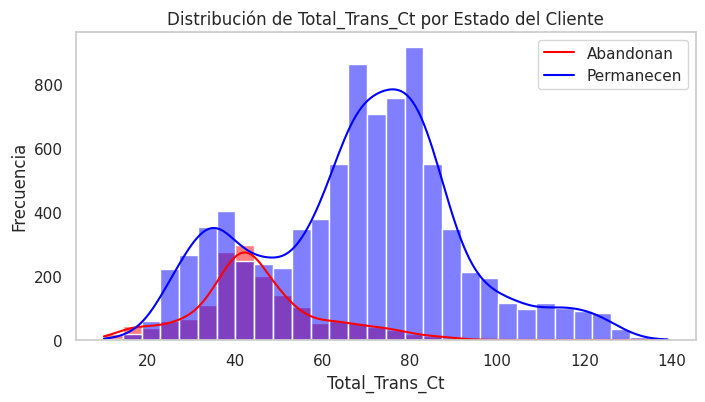

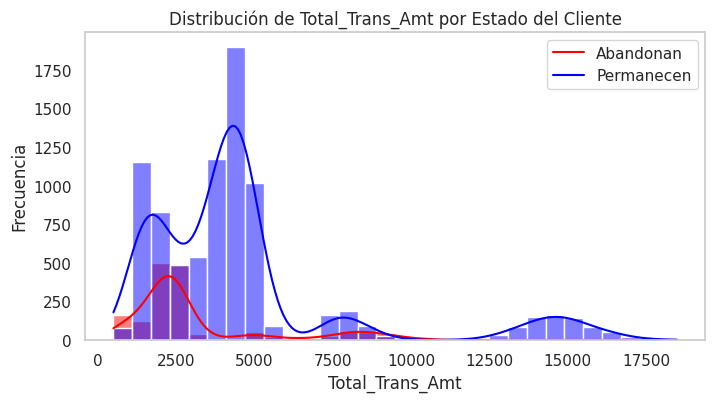

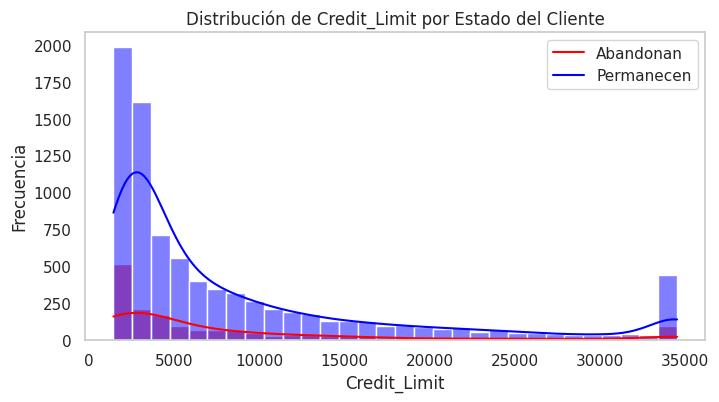

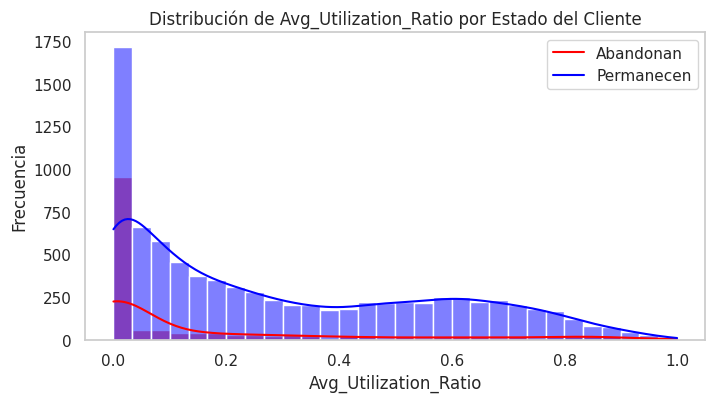

In [68]:
# Definir variables numéricas clave para visualizar
features = ['Total_Trans_Ct', 'Total_Trans_Amt', 'Credit_Limit', 'Avg_Utilization_Ratio']

for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df, x=feature, hue='Attrition_Flag', kde=True, bins=30, palette=['blue', 'red'])
    plt.title(f'Distribución de {feature} por Estado del Cliente')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')
    plt.legend(['Abandonan', 'Permanecen'])
    plt.grid(False)
    plt.show()


A partir de los histogramas generados por el código, podemos observar patrones claros en las variables financieras según el estado del cliente (si abandonan o permanecen). En el gráfico de `Total_Trans_Ct`, se nota que quienes permanecen tienden a tener una mayor cantidad de transacciones mensuales que aquellos que abandonan, lo que sugiere una relación entre mayor uso del producto y menor propensión al abandono. Algo similar ocurre con `Total_Trans_Amt`, donde los clientes que permanecen muestran montos más altos en transacciones, mientras que los que abandonan tienden a agruparse en valores menores. En cuanto al `Credit_Limit`, la distribución está más sesgada hacia valores bajos para quienes abandonan, mientras que los clientes que permanecen presentan una mayor dispersión, accediendo también a límites más altos. Finalmente, el `Avg_Utilization_Ratio` muestra que los clientes que abandonan tienden a tener una utilización baja del crédito disponible, mientras que aquellos que permanecen presentan una mayor diversidad en su ratio de utilización. En conjunto, estos gráficos indican que un mayor uso del producto (en cantidad y monto de transacciones), junto con límites de crédito más altos y ratios de utilización más variados, podrían ser indicadores de mayor fidelidad del cliente.

### Gráfico 11: Relación entre número de transacciones y montos totales

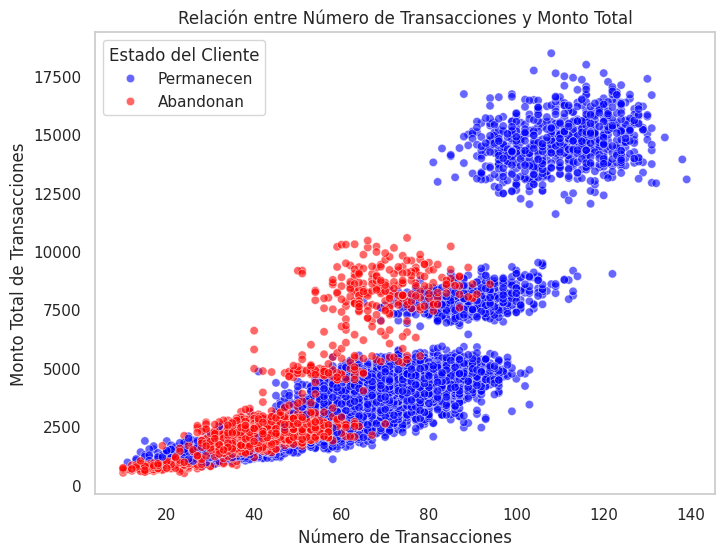

In [24]:
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(data=df, x='Total_Trans_Ct', y='Total_Trans_Amt', hue='Attrition_Flag', palette=['blue', 'red'], alpha=0.6)
plt.title('Relación entre Número de Transacciones y Monto Total')
plt.xlabel('Número de Transacciones')
plt.ylabel('Monto Total de Transacciones')
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles, ['Permanecen', 'Abandonan'], title="Estado del Cliente")
plt.grid(False)
plt.show()


Al observar el Gráfico 11, que compara la distribución de los clientes que abandonan (puntos rojos) con los clientes actuales (puntos azules), se aprecia una tendencia generalizada de los ex clientes a concentrarse en la parte inferior izquierda del diagrama. Esta ubicación sugiere que, en promedio, aquellos que dejaron el banco solían registrar un menor número de transacciones y volúmenes totales de dinero inferiores en comparación con quienes permanecieron. Este hallazgo implica que una actividad reducida, ya sea en términos de cantidad de operaciones o montos transaccionados, podría constituir un indicador relevante para predecir la potencial fuga de un cliente del banco.

### Gráfico 12: Matriz de correlación

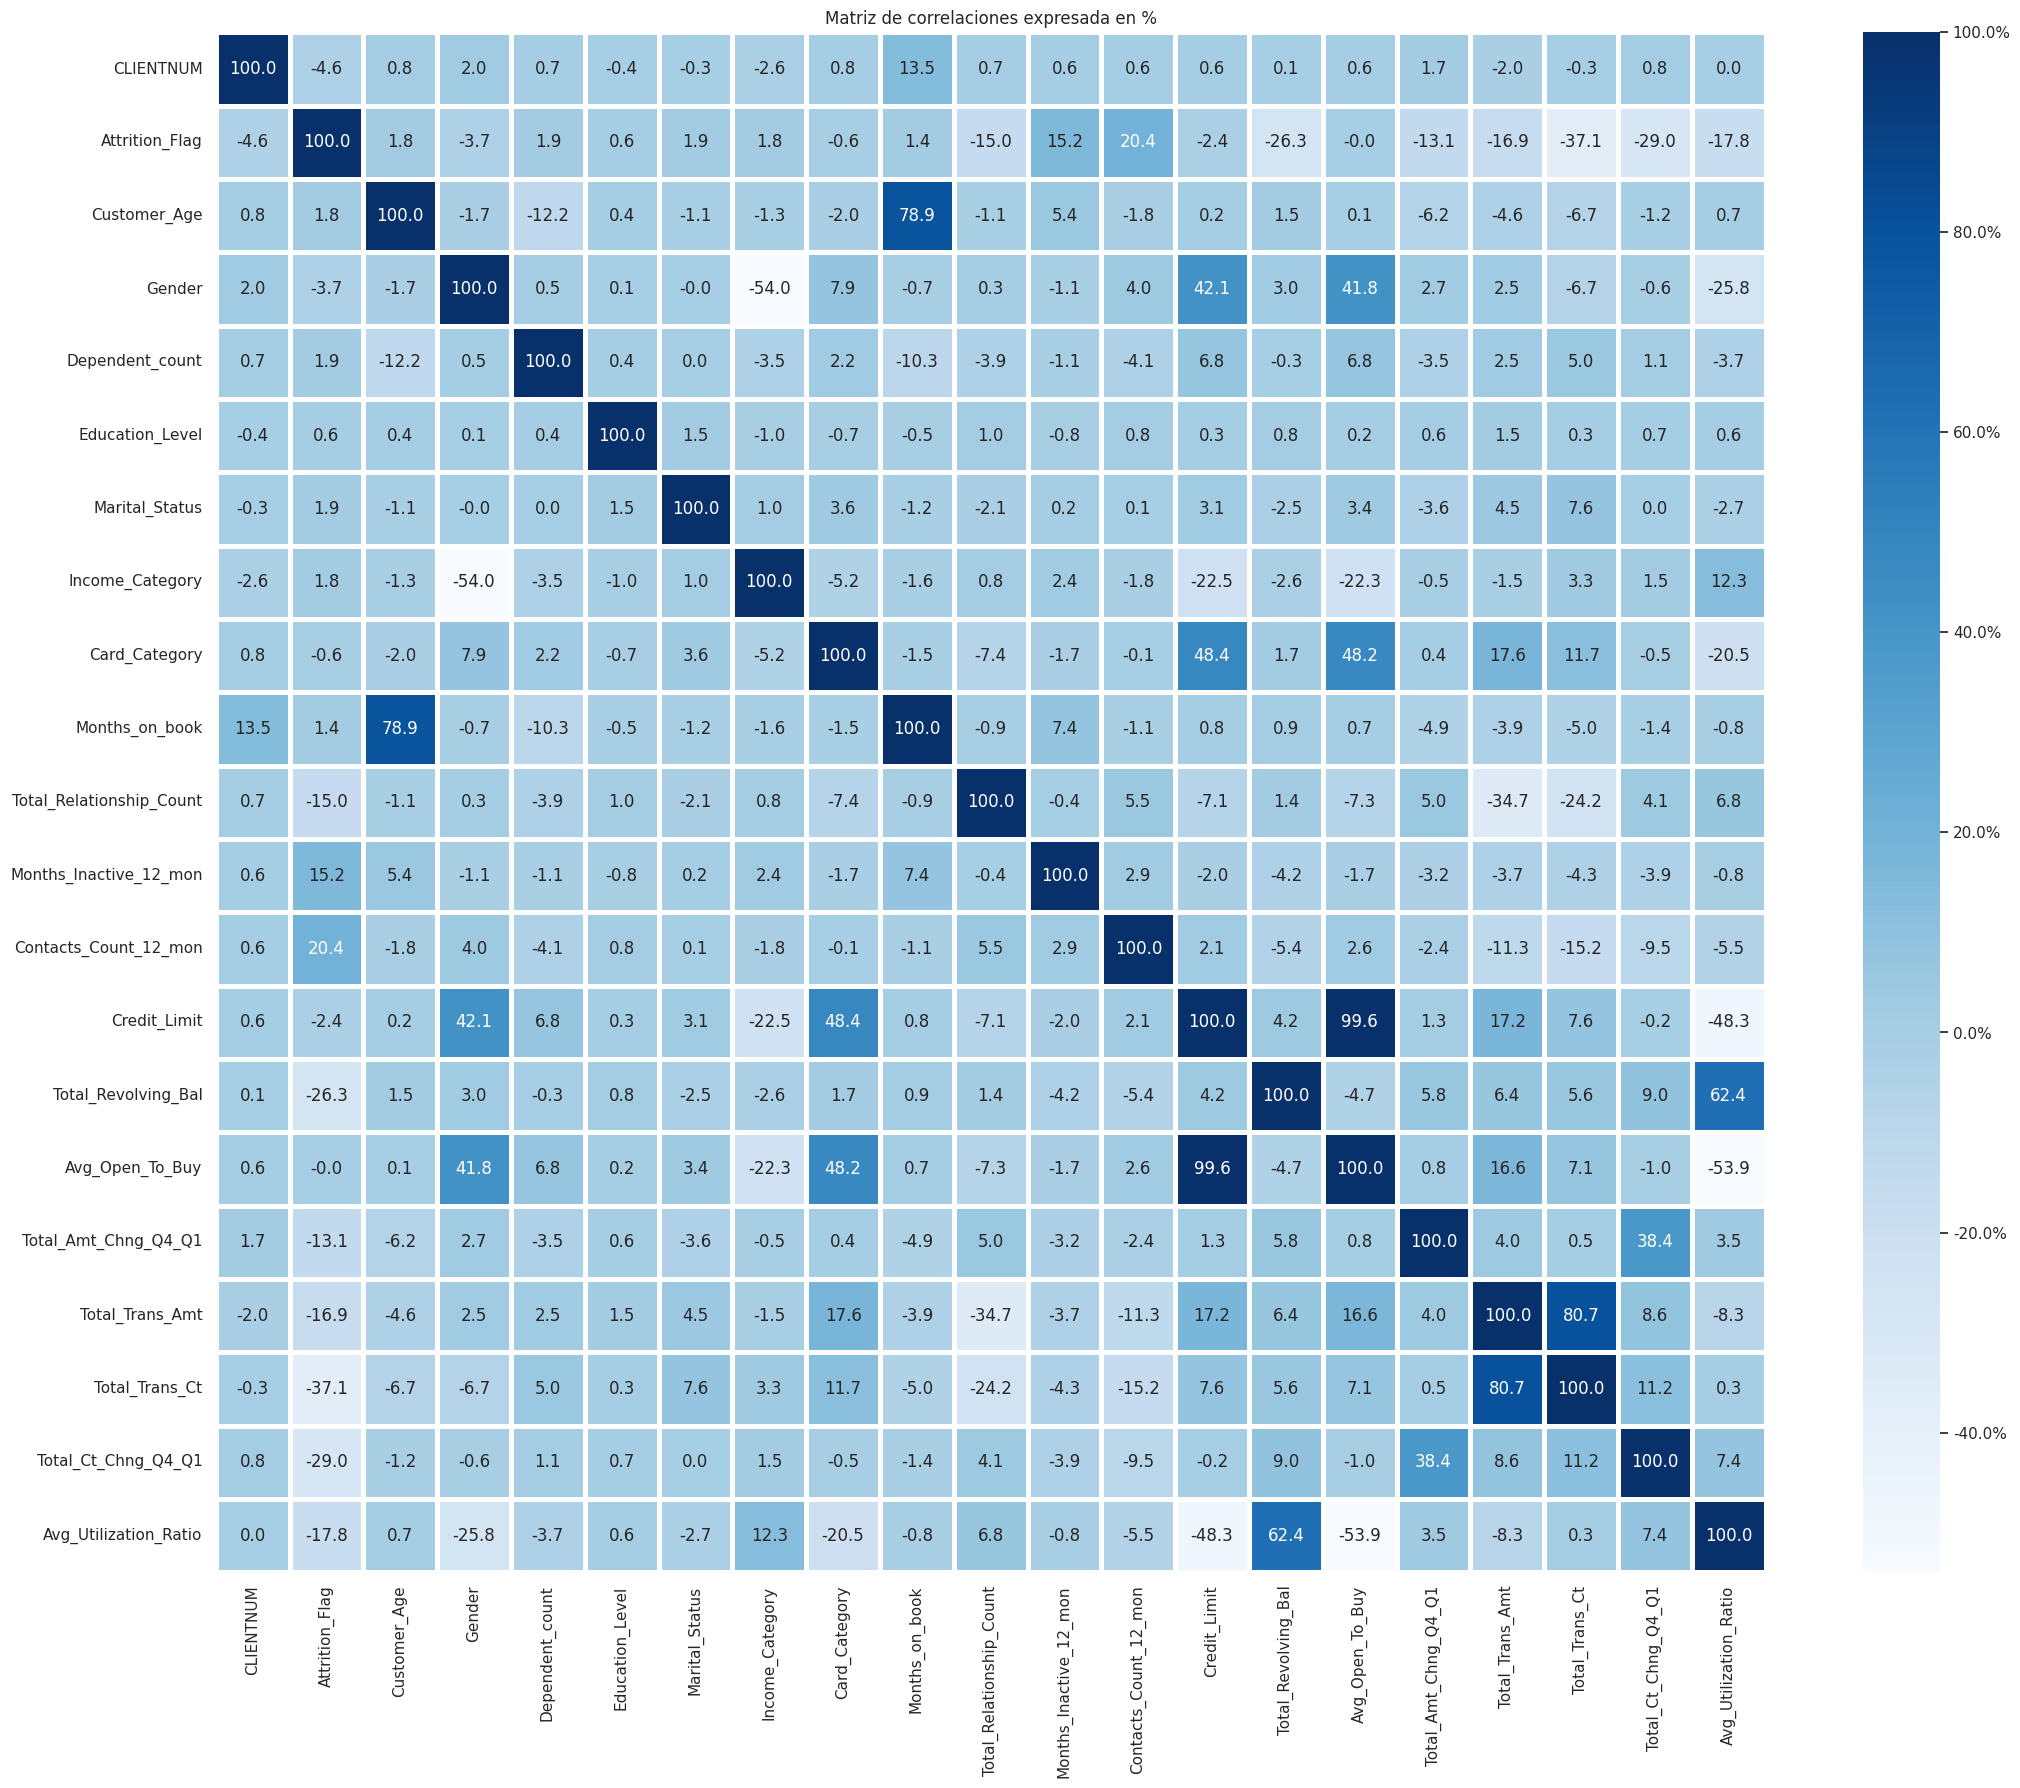

In [69]:
# Transformación variables categóricas a numéricas con el método One Lebel Enconder
label_encoders = {}
categorical_cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Creo la matriz de correlaciones
corrmat = df.corr()
top_corr_features = corrmat.index

plt.figure(figsize=(25, 20))

# Formatear valores como porcentaje con un decimal
g = sns.heatmap(
    df[top_corr_features].corr() * 100,
    annot=True,
    fmt=".1f",  # Un decimal
    cmap="Blues",
    linewidths=3.5,
    linecolor='white',
    cbar_kws={'format': '%.1f%%'})

plt.title("Matriz de correlaciones expresada en %")
plt.show()

De la matriz de correlaciones, los resultados más relevantes con respecto a la variable objetivo **'Attrition_Flag'** son los siguientes:

**Variables con Correlación Negativa :**

* **'Total_Trans_Ct' (-37%):** Esta es la correlación negativa más fuerte con 'Attrition_Flag'. Indica que **los clientes con un mayor número total de transacciones son significativamente menos propensos a abandonar.** Una mayor actividad transaccional parece ser un fuerte indicador de retención.


* **'Total_Trans_Amt' (-16,9%):** Se observa una ligera correlación negativa, sugiriendo que **los clientes con un mayor monto total de transacciones tienen una menor probabilidad de abandonar.** Un mayor volumen de negocio podría indicar una mayor satisfacción o necesidad de los servicios del banco.

* **'Total_Relationship_Count' (-15%):** existe una ligera correlación negativa, indicando que **cuantos más productos o relaciones tiene un cliente con el banco, menor es la probabilidad de que se vaya.** Tener múltiples vínculos con la institución podría aumentar la retención.

* **'Total_Ct_Chng_Q4_Q1' presenta una correlación negativa alta (-29%):** pero esta al ser la variación de 'Total_Trans_Ct'entre el cuarto y el primer trimestre no aporta gran valor explicativo.

**Variables con Correlación Positiva :**

* **'Contacts_Count_12_mon' (20%):** Se observa una correlación positiva considerable, indicando que **cuantas más veces un cliente contactó al banco en los últimos 12 meses, mayor es la probabilidad de que abandone.** Un alto número de contactos podría ser indicativo de problemas, quejas o insatisfacción que finalmente llevan al churn.

* **'Months_Inactive_12_mon' (15%):** Existe una correlación positiva sugiriendo que **cuantos más meses un cliente ha estado inactivo en los últimos 12 meses, mayor es la probabilidad de que abandone.** La inactividad es una señal clara de desvinculación y un fuerte predictor de churn.


**Variables con Correlación Cercana a Cero (Poca o Nula Relación Directa con el Abandono):**

* La mayoría de las variables demográficas ('Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category') muestran correlaciones muy bajas con 'Attrition_Flag'. Esto sugiere que, por sí solas, estas características no son fuertes predictores directos del abandono.

* Las variables relacionadas con el crédito ( por ejemplo 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Avg_Utilization_Ratio'), salvo 'Credit_Limit', también tienen correlaciones negativas y fuertes con 'Attrition_Flag'


**En resumen, los hallazgos más relevantes para predecir el abandono de clientes ('Attrition_Flag') son:**

* **La inactividad reciente ('Months_Inactive_12_mon') como un factor de riesgo significativo.**

* **Un mayor número de contactos con el banco ('Contacts_Count_12_mon') como una posible señal de insatisfacción que podría llevar al abandono.**

* **Un bajo número de transacciones ('Total_Trans_Ct') como un fuerte indicador de potencial abandono.**

* **Menos productos ('Total_Relationship_Count') y un menor volumen de transacciones ('Total_Trans_Amt') como factores  asociados a una mayor probabilidad de abandono.**

Estos resultados sugieren que las variables relacionadas con la **actividad del cliente y su interacción con el banco** son predictores más fuertes del abandono que las características demográficas o las relacionadas directamente con el crédito.

## 2️⃣ Preprocesamiento, Feature Selection y modelado

Accuracy: 0.8845
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      1701
           1       0.63      0.67      0.65       325

    accuracy                           0.88      2026
   macro avg       0.78      0.80      0.79      2026
weighted avg       0.89      0.88      0.89      2026

Confusion Matrix:
 [[1573  128]
 [ 106  219]]


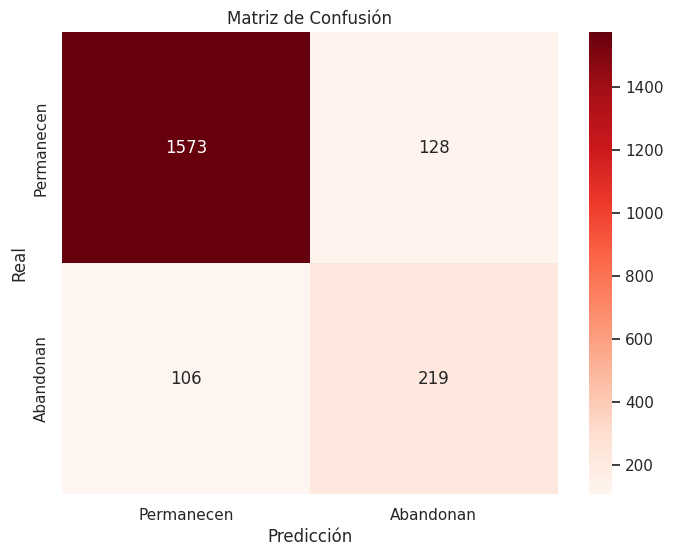

In [45]:
# Separar variables predictoras y objetivo
X = df.drop(columns=['Attrition_Flag','CLIENTNUM'])
y = df['Attrition_Flag']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar SMOTE (después de escalar, antes de PCA)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Aplicar PCA (después del SMOTE)
pca = PCA(n_components=10, random_state=42)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_scaled)

# Entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train_resampled)

# Predicciones
y_pred = model.predict(X_test_pca)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Graficar heatmap con etiquetas
labels = ['Permanecen', 'Abandonan']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

La matriz de confusión es una herramienta utilizada para evaluar el rendimiento de un modelo de clasificación.

0: Clientes que no han abandonado (Existing Customer).

1: Clientes que han abandonado (Attrited Customer).


Verdaderos Negativos (VN): 1573 - El modelo predijo correctamente que 1573 clientes no abandonarían.

Falsos Positivos (FP): 128 - El modelo predijo incorrectamente que 128 clientes abandonarían cuando en realidad no lo hicieron.

Falsos Negativos (FN): 106 - El modelo predijo incorrectamente que 106 clientes no abandonarían el banco cuando en realidad sí lo hicieron.

Verdaderos Positivos (VP): 219 - El modelo predijo correctamente que 219 clientes abandonarían.

---
En primera instancia se aplicó PCA combinado con SMOTE, lo que mejoró el balance de clases pero no arrojó buenos resultados predictivos. Ahora, probaremos usar SelectKBest para seleccionar las variables más relevantes sin reducir la dimensionalidad con el fin de mejorar el modelo.

Accuracy: 0.9556
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      1701
           1       0.90      0.82      0.86       325

    accuracy                           0.96      2026
   macro avg       0.93      0.90      0.91      2026
weighted avg       0.95      0.96      0.95      2026

Confusion Matrix:
 [[1670   31]
 [  59  266]]


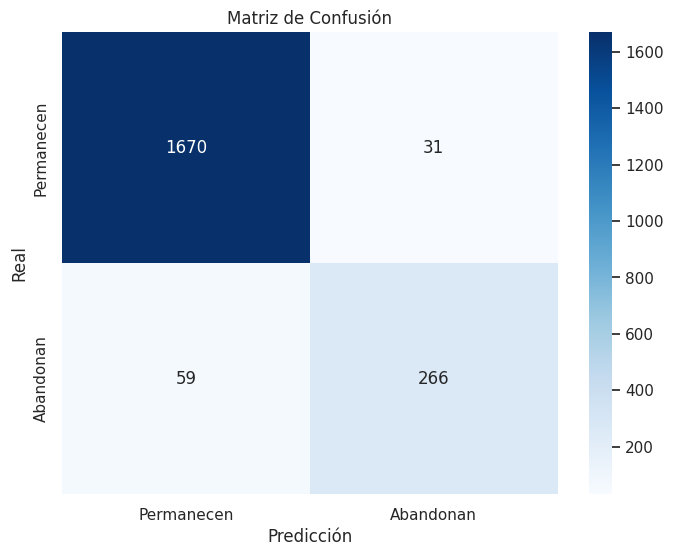

In [46]:
# Separo variables predictoras y objetivo
X = df.drop(columns=['Attrition_Flag','CLIENTNUM'])
y = df['Attrition_Flag']

# Divido en conjunto de entrenamiento y prueba antes de hacer feature selection y normalización
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizar solo después de dividir
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Selección de características sobre el conjunto de entrenamiento
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train)

# Predicciones
y_pred = model.predict(X_test_selected)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Graficar heatmap con etiquetas
labels = ['Permanecen', 'Abandonan']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


0: Clientes que no han abandonado (Existing Customer).

1: Clientes que han abandonado (Attrited Customer).


Verdaderos Negativos (VN): 1670 - El modelo predijo correctamente que 1670 clientes no abandonarían.

Falsos Positivos (FP): 31 - El modelo predijo incorrectamente que 31 clientes abandonarían cuando en realidad no lo hicieron.

Falsos Negativos (FN): 59 - El modelo predijo incorrectamente que 59 clientes no abandonarían cuando en realidad sí lo hicieron.

Verdaderos Positivos (VP): 266 - El modelo predijo correctamente que 266 clientes abandonarían.

## 📌 Conclusión comparativa entre los métodos

En este trabajo se evaluaron dos estrategias distintas para abordar el problema de clasificación de clientes según la variable `Attrition_Flag`, con el objetivo de mejorar la precisión del modelo y su capacidad de generalización.

---

### 🔴 Método 1: SMOTE + PCA (matriz roja)

Este enfoque combinó **SMOTE**, para corregir el desbalance de clases, y **PCA**, para reducir la dimensionalidad del conjunto de datos.

Si bien esta estrategia buscaba equilibrar la información y facilitar el aprendizaje del modelo, los resultados no fueron los esperados. La reducción mediante PCA podría haber eliminado características relevantes, afectando negativamente la capacidad del modelo para distinguir entre clases.

Como se observa en la **matriz de confusión roja**, este método incurrió en una mayor cantidad de errores (falsos positivos y falsos negativos), lo que se tradujo en un rendimiento general inferior.

---

### 🔵 Método 2: SelectKBest (matriz azul)

Este método aplicó una selección de variables basada en la relación estadística entre las características y la variable objetivo, conservando solo las más informativas.

A diferencia del enfoque anterior, no se aplicó sobremuestreo ni reducción de componentes. Esto permitió preservar la estructura natural de los datos y entrenar un modelo más eficaz.

El resultado fue una **mejora significativa en la precisión** y una reducción de los errores de clasificación, como se refleja en la **matriz de confusión azul** donde vemos valores más altos en la diagonal principal (Verdaderos Positivos y Verdaderos Negativos) y valores más bajos en la diagonal secundaria (Falsos Positivos y Falsos Negativos)

---

### ✅ Conclusión sobre el modelo.

Para el objetivo de este trabajo —predecir de forma efectiva la deserción de clientes— el Método 2 (basado en SelectKBest) resultó ser la alternativa más adecuada, ya que obtuvo un desempeño superior sin necesidad de aplicar transformaciones complejas como SMOTE o PCA.

Las métricas de evaluación muestran mejoras significativas:

Accuracy: se incrementó de 0.88 a 0.95.

Recall: pasó de 0.92 (para clase 0) y 0.67 (para clase 1) a 0.98 y 0.82, respectivamente.

F1-score: mejoró de 0.93 (clase 0) y 0.65 (clase 1) a 0.97 y 0.86, respectivamente.




### 🔹 Conclusiones generales

📌 Los clientes que realizan **menos transacciones** y **utilizan con menor frecuencia la tarjeta de crédito** son los más propensos a abandonar el banco, lo que **confirma la hipótesis 1**.

📌 Un **incremento en los contactos con el banco** podría actuar como un **indicador temprano de insatisfacción**, anticipando una posible deserción.

📌 Los clientes con **mayores períodos de inactividad** también muestran una mayor probabilidad de abandonar.

📌 Variables como el **límite de crédito**, la **edad** y la **antigüedad como cliente** **no resultaron ser determinantes** en la decisión de abandonar. Esto sugiere que **la hipótesis 2**, que planteaba que los clientes con mayor límite de crédito tienden a permanecer, **no se sostiene con los datos analizados**.

📌 El análisis de la matriz de correlación parece confirmar la hipótesis 3 que afirma que no hay grandes diferencias en género, nivel educativo o estado civil entre aquellos que fueron clientes del banco y aquellos actuales.

---

### 🔹 Recomendaciones

✅ **Implementar programas de fidelización** que premien el uso frecuente de la tarjeta y fomenten una mayor interacción con los productos bancarios.

✅ **Capacitar al personal de atención al cliente** para abordar inquietudes con rapidez, eficacia y empatía, mejorando así la experiencia del cliente.

✅ **Lanzar campañas proactivas** (vía email o mensajes de texto) para **estimular la reactivación** de clientes inactivos, recordándoles los beneficios de los servicios ofrecidos.

✅ **Realizar encuestas o entrevistas a clientes inactivos** para comprender mejor las causas del desuso o abandono, y así orientar políticas de retención más efectivas.
